In [1]:
# !pip install av
# ! wget https://raw.githubusercontent.com/pytorch/vision/6de158c473b83cf43344a0651d7c01128c7850e6/references/video_classification/transforms.py
# # Download HMDB51 data and splits from serre lab website
# ! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
# ! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

In [2]:
# pip install git+https://github.com/Atze00/MoViNet-pytorch.git


In [3]:
# Extract and organize video data..
# ! mkdir -p video_data test_train_splits
# ! unrar e test_train_splits.rar test_train_splits
# ! rm test_train_splits.rar
# ! unrar e hmdb51_org.rar 
# ! rm hmdb51_org.rar
# ! mv *.rar video_data
# import os
# for files in os.listdir('video_data'):
#     foldername = files.split('.')[0]
#     os.system("mkdir -p video_data/" + foldername)
#     os.system("unrar e video_data/"+ files + " video_data/"+foldername)

# ! rm video_data/*.rar


In [4]:
import time
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Dataset
import torch
import transforms as T
from movinets import MoViNet
from movinets.config import _C
import object_detector
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torchinfo

torch.manual_seed(97)
num_frames = 16 # 16
clip_steps = 2
Bs_Train = 32
Bs_Test = 32
frame_size = (172, 172)

class SOPDataloader(Dataset):
    def __init__(
            self,dataset_path=None, train=True, frame_size=(200,200),
            frames_per_clip=6, step_between_clips = 4, transform=None, transformHand=None,
            label_file='label_map_sop.txt', annotation_path='sop_annotation.txt'
        ):
        
        self.step_between_clips = step_between_clips
        self.frames_per_clip = frames_per_clip
        self.transform = transform
        self.videoBuffer = []
        self.detector = object_detector.Predictor()
        self.class_names = []
        f = open(dataset_path+annotation_path, 'r')
        for line in f:
            self.class_names.append(line[:-1])
        f.close()
        annotation = np.genfromtxt(dataset_path+annotation_path, delimiter=',', dtype=str)
        self.labels = []
        self.video_paths = []
        if train is None:
            annotation = annotation[928:1160]
            self.a = 0
            self.b = 231
        elif train:
            annotation = annotation[:696]
            self.a = 0
            self.b = 695
        else:
            annotation = annotation[696:928]
            self.a = 0
            self.b = 231
            
        for i in annotation:
            self.video_paths.append(dataset_path + i[0])
            self.labels.append(int(i[1]))
            
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        while True:
            cap = cv2.VideoCapture(self.video_paths[idx])
            self.videoBuffer = []
            c = 0
            s = self.step_between_clips
            boundingBoxes = []
            t0 = time.time()
            ret, frame = cap.read()
            while ret:
                if s == self.step_between_clips:
                    # detect people here
                    cropped_frame, box = self.detector.detect(frame, getBestOnly=True)
                    if cropped_frame is None:
                        ret, frame = cap.read()
                        continue
                    c += 1
#                     print(cropped_frame)
                    self.videoBuffer.append(cv2.resize(cropped_frame, frame_size, interpolation=cv2.INTER_LINEAR))
                    if c == self.frames_per_clip:
                        self.videoBuffer = torch.from_numpy(np.array(self.videoBuffer, dtype=np.float32))
                        if self.transform != None:
                            if self.labels[idx] != 4 or self.labels[idx] != 6:
                                self.videoBuffer = self.transform(self.videoBuffer)
                            elif transformHand != None and (self.labels[idx] == 4 or self.labels[idx] == 6):
                                self.videoBuffer = self.transformHand(self.videoBuffer)
                        cap.release()
    #                     print("reading time: {:.4f}s".format(time.time() - t0))
#                         print(self.a, idx, self.video_paths[idx])
    #                     return torch.from_numpy(np.expand_dims(self.videoBuffer, axis=0)), self.labels[idx]
                        return self.videoBuffer, 0, self.labels[idx]
                    s = 0
                else:
                    s += 1
                ret, frame = cap.read()
            print('ERROR NOT ENOUGH VIDEO LENGTH: ', self.video_paths[idx])
            cap.release()
            
            idx = int(random.uniform(self.a, self.b))

transform = transforms.Compose([  
                                                     
                                 T.ToFloatTensorInZeroOne(),
                                 T.Resize(frame_size),
                                 T.RandomHorizontalFlip()])#,
                                 #T.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
                                 #T.RandomCrop((172, 172))])
transform_test = transforms.Compose([                           
                                 T.ToFloatTensorInZeroOne(),
                                 T.Resize(frame_size)])#,
                                 #T.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
                                 #T.CenterCrop((172, 172))])
trainSOP = True
trainHMDB = True
if trainHMDB:
    hmdb51_train = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames,frame_rate=5,
                                                    step_between_clips = clip_steps, fold=1, train=True,
                                                    transform=transform, num_workers=2)


    hmdb51_test = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames,frame_rate=5,
                                                step_between_clips = clip_steps, fold=1, train=False,
                                                transform=transform_test, num_workers=2)

    train_loader_hmdb = DataLoader(hmdb51_train, batch_size=Bs_Train, shuffle=True)
    test_loader_hmdb  = DataLoader(hmdb51_test, batch_size=Bs_Test, shuffle=False)
if trainSOP:
    sop_train = SOPDataloader('sop_dataset/', train=True, frame_size=frame_size, transform=transform_test, transformHand = transform_test)
    sop_val = SOPDataloader('sop_dataset/', train=False, frame_size=frame_size, transform=transform_test, transformHand = transform_test)
    sop_test = SOPDataloader('sop_dataset/', train=None, frame_size=frame_size, transform=transform_test, transformHand = transform_test)
    train_loader = DataLoader(sop_train, batch_size=Bs_Train, shuffle=True)
    val_loader  = DataLoader(sop_val, batch_size=Bs_Test, shuffle=False)
    test_loader = DataLoader(sop_test, batch_size=Bs_Test, shuffle=False)

/home/ma012/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 423/423 [00:43<00:00,  9.62it/s]
/home/ma012/miniconda3/lib/python3.8/site-packages/torchvision/datasets/video_utils.py:219: UserWarning: There aren't enough frames in the current video to get a clip for the given clip length and frames between clips. The video (and potentially others) will be skipped.
  warnings.warn(
100%|██████████| 423/423 [00:44<00:00,  9.56it/s]


In [5]:
def train_iter(model, optimz, data_load, loss_val):
    samples = len(data_load.dataset)
    model.train()
    model.cuda()
    model.clean_activation_buffers()
    optimz.zero_grad()
    for i, (data, _, target) in enumerate(data_load):
        out = F.log_softmax(model(data.cuda()), dim=1)
        loss = F.nll_loss(out, target.cuda())
        loss.backward()
        optimz.step()
        optimz.zero_grad()
        model.clean_activation_buffers()
        if i % 4 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_load)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_val.append(loss.item())
        t0 = time.time()
 
def evaluate(model, data_load, loss_val):
    model.eval()
    
    samples = len(data_load.dataset)
    csamp = 0
    tloss = 0
    model.clean_activation_buffers()
    with torch.no_grad():
        for data, _, target in data_load:
            output = F.log_softmax(model(data.cuda()), dim=1)
            loss = F.nll_loss(output, target.cuda(), reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            tloss += loss.item()
            csamp += pred.eq(target.cuda()).sum()
            model.clean_activation_buffers()
    aloss = tloss / samples
    loss_val.append(aloss)
    print('\nAverage test loss: ' + '{:.4f}'.format(aloss) +
          '  Accuracy:' + '{:5}'.format(csamp) + '/' +
          '{:5}'.format(samples) + ' (' +
          '{:4.2f}'.format(100.0 * csamp / samples) + '%)\n')
    
def train_iter_stream(model, optimz, data_load, loss_val, n_clips = 2, n_clip_frames=8):
    """
    In causal mode with stream buffer a single video is fed to the network
    using subclips of lenght n_clip_frames. 
    n_clips*n_clip_frames should be equal to the total number of frames presents
    in the video.
    
    n_clips : number of clips that are used
    n_clip_frames : number of frame contained in each clip
    """
    #clean the buffer of activations
    samples = len(data_load.dataset)
    model.cuda()
    model.train()
    model.clean_activation_buffers()
    optimz.zero_grad()
    
    for i, (data,_, target) in enumerate(data_load):
        data = data.cuda()
        target = target.cuda()
        l_batch = 0
        #backward pass for each clip
        for j in range(n_clips):
          output = F.log_softmax(model(data[:,:,(n_clip_frames)*(j):(n_clip_frames)*(j+1)]), dim=1)
          loss = F.nll_loss(output, target)
          _, pred = torch.max(output, dim=1)
          loss = F.nll_loss(output, target)/n_clips
          loss.backward()
        l_batch += loss.item()*n_clips
        optimz.step()
        optimz.zero_grad()
        
        #clean the buffer of activations
        model.clean_activation_buffers()
        if i % 50 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_load)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(l_batch))
            loss_val.append(l_batch)

def evaluate_stream(model, data_load, loss_val, n_clips = 2, n_clip_frames=8):
    model.eval()
    model.cuda()
    samples = len(data_load.dataset)
    csamp = 0
    tloss = 0
    with torch.no_grad():
        for data, _, target in data_load:
            data = data.cuda()
            target = target.cuda()
            model.clean_activation_buffers()
            for j in range(n_clips):
              output = F.log_softmax(model(data[:,:,(n_clip_frames)*(j):(n_clip_frames)*(j+1)]), dim=1)
              loss = F.nll_loss(output, target)
            _, pred = torch.max(output, dim=1)
            tloss += loss.item()
            csamp += pred.eq(target).sum()

    aloss = tloss /  len(data_load)
    loss_val.append(aloss)
    print('\nAverage test loss: ' + '{:.4f}'.format(aloss) +
          '  Accuracy:' + '{:5}'.format(csamp) + '/' +
          '{:5}'.format(samples) + ' (' +
          '{:4.2f}'.format(100.0 * csamp / samples) + '%)\n')

In [24]:
if trainHMDB:
    N_EPOCHS = 15
    hmdbPretrained = False
    sopPretrained = False
    modelPath = 'model_state_dict_newmodel.pkl'
    model = MoViNet(_C.MODEL.MoViNetA0, causal = False, pretrained = False)
    model = torch.load(modelPath)
    # model.classifier[3] = torch.nn.Conv3d(1024, 51, (1,1,1))
    start_time = time.time()

    trloss_val, tsloss_val, tsloss = [], [], []
    optimz = optim.RMSprop(model.parameters(), lr=0.00001, momentum=0.9)
    # optimz = optim.Adam(model.parameters(), lr=0.00001)
    for epoch in range(1, N_EPOCHS + 1):
        print('Epoch:', epoch)
        train_iter(model, optimz, train_loader_hmdb, trloss_val)
        print('EVALUATING')
        evaluate(model, test_loader_hmdb, tsloss_val)

    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    torch.save(model, modelPath)

Epoch: 1
[    0/ 7519 (  0%)]  Loss: 1.5368
[  128/ 7519 (  2%)]  Loss: 1.5502
[  256/ 7519 (  3%)]  Loss: 2.6061
[  384/ 7519 (  5%)]  Loss: 1.6472
[  512/ 7519 (  7%)]  Loss: 1.7999
[  640/ 7519 (  9%)]  Loss: 1.6786
[  768/ 7519 ( 10%)]  Loss: 1.7688
[  896/ 7519 ( 12%)]  Loss: 1.7039
[ 1024/ 7519 ( 14%)]  Loss: 2.4801
[ 1152/ 7519 ( 15%)]  Loss: 1.7836
[ 1280/ 7519 ( 17%)]  Loss: 1.3535
[ 1408/ 7519 ( 19%)]  Loss: 1.7800
[ 1536/ 7519 ( 20%)]  Loss: 1.5241
[ 1664/ 7519 ( 22%)]  Loss: 1.6893
[ 1792/ 7519 ( 24%)]  Loss: 1.6879
[ 1920/ 7519 ( 26%)]  Loss: 2.1610
[ 2048/ 7519 ( 27%)]  Loss: 1.7097
[ 2176/ 7519 ( 29%)]  Loss: 1.6115
[ 2304/ 7519 ( 31%)]  Loss: 1.6834
[ 2432/ 7519 ( 32%)]  Loss: 1.4181
[ 2560/ 7519 ( 34%)]  Loss: 1.6026
[ 2688/ 7519 ( 36%)]  Loss: 1.4650
[ 2816/ 7519 ( 37%)]  Loss: 1.8244
[ 2944/ 7519 ( 39%)]  Loss: 1.5023
[ 3072/ 7519 ( 41%)]  Loss: 1.6512
[ 3200/ 7519 ( 43%)]  Loss: 1.8601
[ 3328/ 7519 ( 44%)]  Loss: 1.4573
[ 3456/ 7519 ( 46%)]  Loss: 1.4248
[ 3584/ 751

[ 6528/ 7519 ( 87%)]  Loss: 1.0490
[ 6656/ 7519 ( 89%)]  Loss: 0.9245
[ 6784/ 7519 ( 90%)]  Loss: 1.2170
[ 6912/ 7519 ( 92%)]  Loss: 0.8279
[ 7040/ 7519 ( 94%)]  Loss: 0.9690
[ 7168/ 7519 ( 95%)]  Loss: 0.7954
[ 7296/ 7519 ( 97%)]  Loss: 1.0018
[ 7424/ 7519 ( 99%)]  Loss: 0.7317
EVALUATING

Average test loss: 3.6799  Accuracy:  793/ 2944 (26.94%)

Epoch: 5
[    0/ 7519 (  0%)]  Loss: 0.6198
[  128/ 7519 (  2%)]  Loss: 0.6259
[  256/ 7519 (  3%)]  Loss: 1.0829
[  384/ 7519 (  5%)]  Loss: 1.2915
[  512/ 7519 (  7%)]  Loss: 0.8100
[  640/ 7519 (  9%)]  Loss: 1.0417
[  768/ 7519 ( 10%)]  Loss: 1.0318
[  896/ 7519 ( 12%)]  Loss: 0.7551
[ 1024/ 7519 ( 14%)]  Loss: 0.9248
[ 1152/ 7519 ( 15%)]  Loss: 1.0779
[ 1280/ 7519 ( 17%)]  Loss: 0.9169
[ 1408/ 7519 ( 19%)]  Loss: 0.8125
[ 1536/ 7519 ( 20%)]  Loss: 1.2602
[ 1664/ 7519 ( 22%)]  Loss: 0.9994
[ 1792/ 7519 ( 24%)]  Loss: 1.0536
[ 1920/ 7519 ( 26%)]  Loss: 0.7860
[ 2048/ 7519 ( 27%)]  Loss: 0.9320
[ 2176/ 7519 ( 29%)]  Loss: 0.8508
[ 2304/ 751

[ 5248/ 7519 ( 70%)]  Loss: 0.7034
[ 5376/ 7519 ( 71%)]  Loss: 0.5758
[ 5504/ 7519 ( 73%)]  Loss: 0.4076
[ 5632/ 7519 ( 75%)]  Loss: 0.2420
[ 5760/ 7519 ( 77%)]  Loss: 0.4968
[ 5888/ 7519 ( 78%)]  Loss: 0.9935
[ 6016/ 7519 ( 80%)]  Loss: 0.6907
[ 6144/ 7519 ( 82%)]  Loss: 0.5521
[ 6272/ 7519 ( 83%)]  Loss: 0.6368
[ 6400/ 7519 ( 85%)]  Loss: 0.4667
[ 6528/ 7519 ( 87%)]  Loss: 0.4147
[ 6656/ 7519 ( 89%)]  Loss: 0.2926
[ 6784/ 7519 ( 90%)]  Loss: 0.2300
[ 6912/ 7519 ( 92%)]  Loss: 0.4197
[ 7040/ 7519 ( 94%)]  Loss: 0.6370
[ 7168/ 7519 ( 95%)]  Loss: 0.6060
[ 7296/ 7519 ( 97%)]  Loss: 0.4190
[ 7424/ 7519 ( 99%)]  Loss: 0.7973
EVALUATING

Average test loss: 4.2011  Accuracy:  803/ 2944 (27.28%)

Epoch: 9
[    0/ 7519 (  0%)]  Loss: 0.3544
[  128/ 7519 (  2%)]  Loss: 0.7434
[  256/ 7519 (  3%)]  Loss: 0.5632
[  384/ 7519 (  5%)]  Loss: 0.2985
[  512/ 7519 (  7%)]  Loss: 1.1653
[  640/ 7519 (  9%)]  Loss: 0.3327
[  768/ 7519 ( 10%)]  Loss: 0.5734
[  896/ 7519 ( 12%)]  Loss: 0.9912
[ 1024/ 751

[ 3840/ 7519 ( 51%)]  Loss: 0.4673
[ 3968/ 7519 ( 53%)]  Loss: 0.4180
[ 4096/ 7519 ( 54%)]  Loss: 0.2322
[ 4224/ 7519 ( 56%)]  Loss: 0.5960
[ 4352/ 7519 ( 58%)]  Loss: 0.4690
[ 4480/ 7519 ( 60%)]  Loss: 0.3707
[ 4608/ 7519 ( 61%)]  Loss: 0.1839
[ 4736/ 7519 ( 63%)]  Loss: 0.5030
[ 4864/ 7519 ( 65%)]  Loss: 0.4853
[ 4992/ 7519 ( 66%)]  Loss: 0.4598
[ 5120/ 7519 ( 68%)]  Loss: 0.3348
[ 5248/ 7519 ( 70%)]  Loss: 0.3206
[ 5376/ 7519 ( 71%)]  Loss: 0.6463
[ 5504/ 7519 ( 73%)]  Loss: 0.3589
[ 5632/ 7519 ( 75%)]  Loss: 0.2180
[ 5760/ 7519 ( 77%)]  Loss: 0.3578
[ 5888/ 7519 ( 78%)]  Loss: 0.4567
[ 6016/ 7519 ( 80%)]  Loss: 0.4461
[ 6144/ 7519 ( 82%)]  Loss: 0.1964
[ 6272/ 7519 ( 83%)]  Loss: 0.2285
[ 6400/ 7519 ( 85%)]  Loss: 0.1125
[ 6528/ 7519 ( 87%)]  Loss: 0.4610
[ 6656/ 7519 ( 89%)]  Loss: 0.5720
[ 6784/ 7519 ( 90%)]  Loss: 0.4610
[ 6912/ 7519 ( 92%)]  Loss: 0.2375
[ 7040/ 7519 ( 94%)]  Loss: 0.2866
[ 7168/ 7519 ( 95%)]  Loss: 0.3618
[ 7296/ 7519 ( 97%)]  Loss: 0.5974
[ 7424/ 7519 ( 99%)]

In [28]:
 if trainSOP:
    N_EPOCHS = 20
    hmdbPretrained = True
    sopPretrained = False
    modelPath = 'model_state_dict_newmodel.pkl'
    model = MoViNet(_C.MODEL.MoViNetA0, causal = False, pretrained = False )
    if hmdbPretrained:
        model = torch.load(modelPath)
    modelPath = 'model_state_dict_sop_.pkl'
    if not sopPretrained:
        model.classifier[3] = torch.nn.Conv3d(1024, 8, (1,1,1))

    start_time = time.time()

    trloss_val, tsloss_val, tsloss = [], [], []
    optimz = optim.RMSprop(model.parameters(), lr=0.000005, momentum=0.9)
    # optimz = optim.Adam(model.parameters(), lr=0.00001)
    for epoch in range(1, N_EPOCHS + 1):
        print('Epoch:', epoch)
        train_iter(model, optimz, train_loader, trloss_val)
        print('EVALUATING')
        evaluate(model, val_loader, tsloss_val)

    print('TESTING')
    evaluate(model, test_loader, tsloss)
    print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')
    torch.save(model, modelPath)

Epoch: 1
[    0/  696 (  0%)]  Loss: 2.2945
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200125.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200047.mp4
[  128/  696 ( 18%)]  Loss: 1.9440
[  256/  696 ( 36%)]  Loss: 1.6460
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200036.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200139.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200002.mp4
[  384/  696 ( 55%)]  Loss: 1.4571
[  512/  696 ( 73%)]  Loss: 1.1587
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200003.mp4
[  640/  696 ( 91%)]  Loss: 1.1541
EVALUATING
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200061.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200001.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200048.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200101.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200008.mp4

Average test loss: 1.0298  Accuracy:  178/ 


Average test loss: 0.1218  Accuracy:  229/  232 (98.71%)

Epoch: 9
[    0/  696 (  0%)]  Loss: 0.1891
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200047.mp4
[  128/  696 ( 18%)]  Loss: 0.1349
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200125.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200036.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200002.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200003.mp4
[  256/  696 ( 36%)]  Loss: 0.1024
[  384/  696 ( 55%)]  Loss: 0.0964
[  512/  696 ( 73%)]  Loss: 0.1573
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200139.mp4
[  640/  696 ( 91%)]  Loss: 0.2801
EVALUATING
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200061.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200001.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200048.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200101.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_le

[    0/  696 (  0%)]  Loss: 0.0237
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200002.mp4
[  128/  696 ( 18%)]  Loss: 0.0173
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200139.mp4
[  256/  696 ( 36%)]  Loss: 0.0208
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200036.mp4
[  384/  696 ( 55%)]  Loss: 0.0092
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200047.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200125.mp4
[  512/  696 ( 73%)]  Loss: 0.0457
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200003.mp4
[  640/  696 ( 91%)]  Loss: 0.0301
EVALUATING
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200061.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200001.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200048.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200048.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs/0200101.mp4
ERROR NOT ENOUGH VIDEO LENGTH:  sop_dataset/back_legs

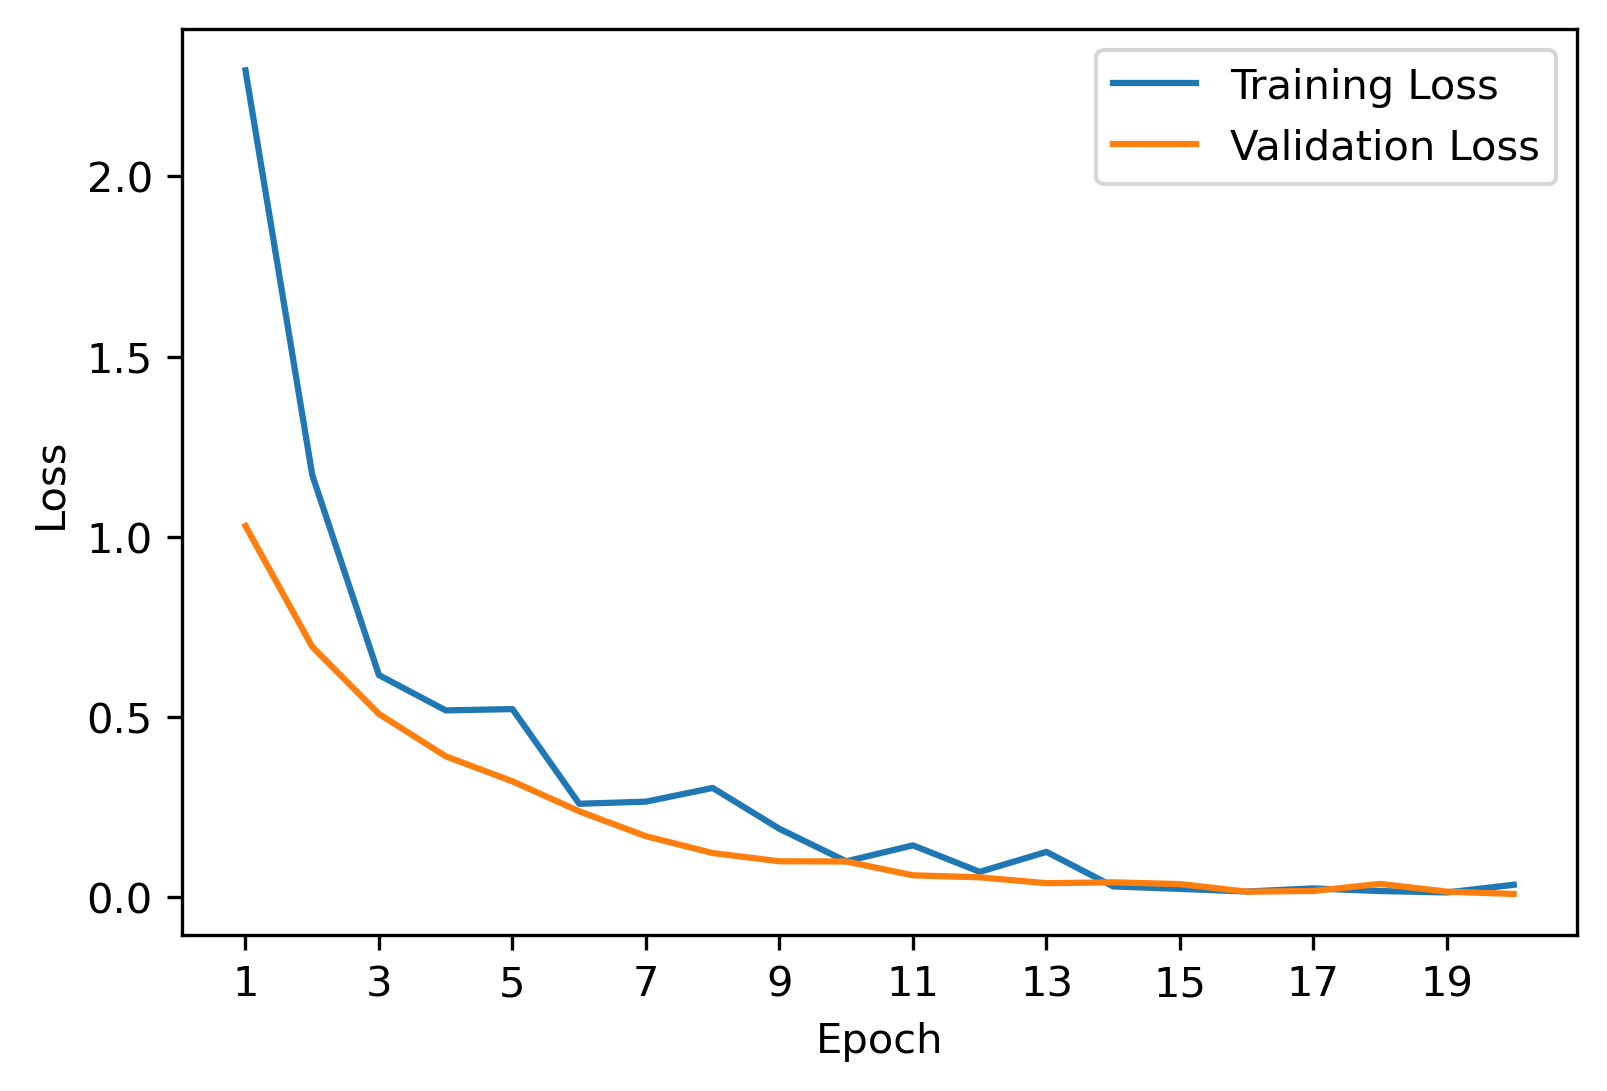

In [42]:
training_loss = np.array(trloss_val)
validation_loss = np.array(tsloss_val)
plt.rcParams['figure.dpi'] = 300
l = list(range(0, 120, 6))
fig, ax = plt.subplots(1,1)
ax.plot(training_loss[l], label='Training Loss')
ax.plot(validation_loss, label='Validation Loss')
xpositions = list(range(len(l)))
xlabels = [str(i) for i in range(1, len(l)+1, 2)]
ax.xaxis.set_major_locator(ticker.FixedLocator(xpositions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))
ax.locator_params(nbins=10)
ax.legend()
plt.xlabel('Epoch', axes=ax)
plt.ylabel('Loss', axes=ax)
plt.show()

In [ ]:
xlabel

In [41]:
torchinfo.summary(model, input_size=[32, 3, 6, 172, 172])

Layer (type:depth-idx)                                  Output Shape              Param #
MoViNet                                                 [32, 8]                   --
├─ConvBlock3D: 1-1                                      [32, 8, 6, 86, 86]        --
│    └─Conv3DBNActivation: 2-1                          [32, 8, 6, 86, 86]        --
│    │    └─Conv3d: 3-1                                 [32, 8, 6, 86, 86]        216
│    │    └─BatchNorm3d: 3-2                            [32, 8, 6, 86, 86]        16
│    │    └─Swish: 3-3                                  [32, 8, 6, 86, 86]        --
├─Sequential: 1-2                                       [32, 104, 6, 5, 5]        --
│    └─BasicBneck: 2-2                                  [32, 8, 6, 43, 43]        1
│    │    └─Sequential: 3-4                             [32, 8, 6, 43, 43]        80
│    │    └─ConvBlock3D: 3-5                            [32, 24, 6, 86, 86]       240
│    │    └─ConvBlock3D: 3-6                            [32

In [40]:
for i, (data, _, target) in enumerate(train_loader):
    print(data.shape)
    break

torch.Size([32, 3, 6, 172, 172])


In [ ]:
# N_EPOCHS = 10

# modelPath = 'model_state_dict_stream.pkl'
# model = MoViNet(_C.MODEL.MoViNetA0, causal = True, pretrained = True )
# # model.load_state_dict(torch.load(modelPath))
# start_time = time.time()

# trloss_val, tsloss_val = [], []
# model.classifier[3] = torch.nn.Conv3d(2048, 51, (1,1,1))
# optimz = optim.Adam(model.parameters(), lr=0.00005)
# for epoch in range(1, N_EPOCHS + 1):
#     print('Epoch:', epoch)
#     train_iter_stream(model, optimz, train_loader, trloss_val)
#     evaluate_stream(model, test_loader, tsloss_val)
    
# torch.save(model, modelPath)
# print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

import os
import pandas as pd
from torchvision.io import read_image
import cv2
import numpy as np
from torch.utils.data import Dataset
import torch

class RealtimeVideoInference(Dataset):
    def __init__(self, cam_index=0, frames_per_clip=16, step_between_clips = 2, transform=None):
        self.cap = cv2.VideoCapture(cam_index)
        self.step_between_clips = step_between_clips
        self.frames_per_clip = frames_per_clip
        self.transform = transform
        self.videoBuffer = []

    def __len__(self):
        return len(self.videoBuffer)

    def __getitem__(self, idx):
        self.videoBuffer = []
        c = 0
        s = self.step_between_clips
        ret, frame = self.cap.read()
        while ret:
            if s == self.step_between_clips:
                c += 1
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                self.videoBuffer.append(frame)
                if c == self.frames_per_clip:
                    self.videoBuffer = torch.from_numpy(np.array(self.videoBuffer))
                    if self.transform != None:
                        self.videoBuffer = self.transform(self.videoBuffer)
                    return torch.from_numpy(np.expand_dims(self.videoBuffer, axis=0)), None
                s = 0
            else:
                s += 1
            ret, frame = self.cap.read()

camera = RealtimeVideoInference(transform=transform_test)
model.clean_activation_buffers()
n_clips = 2
data, _ = camera.__getitem__(0)
data = data.cuda()
n_clip_frames = 8
for j in range(n_clips):
  output = F.log_softmax(model(data[:,:,(n_clip_frames)*(j):(n_clip_frames)*(j+1)]), dim=1)
_, pred = torch.max(output, dim=1)
print(pred)
vid, _ = camera.__getitem__(0)
# print(vid)
print(data.shape)

In [ ]:
# hmdb51_test = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames,frame_rate=5,
#                                                 step_between_clips = clip_steps, fold=1, train=False,
#                                                 transform=transform_test, num_workers=2)

In [ ]:
# v, _, label = hmdb51_test.__getitem__(2000)
# print(v.shape)

In [ ]:
# def dataloaderChecker(model, data_load, loss_val, n_clips = 2, n_clip_frames=8):
#     model.eval()
#     model.cuda()
#     samples = len(data_load.dataset)
#     csamp = 0
#     tloss = 0
#     with torch.no_grad():
#         for data, _, target in data_load:
#             print(data.shape, _.shape, target.shape)
#             data = data.cuda()
#             target = target.cuda()
#             model.clean_activation_buffers()
#             for j in range(n_clips):
#               output = F.log_softmax(model(data[:,:,(n_clip_frames)*(j):(n_clip_frames)*(j+1)]), dim=1)
#               loss = F.nll_loss(output, target)
#             _, pred = torch.max(output, dim=1)
#             tloss += loss.item()
#             csamp += pred.eq(target).sum()

#     aloss = tloss /  len(data_load)
#     loss_val.append(aloss)
#     print('\nAverage test loss: ' + '{:.4f}'.format(aloss) +
#           '  Accuracy:' + '{:5}'.format(csamp) + '/' +
#           '{:5}'.format(samples) + ' (' +
#           '{:4.2f}'.format(100.0 * csamp / samples) + '%)\n')

In [ ]:
# num_frames = 16 # 16
# clip_steps = 2
# Bs_Train = 16
# Bs_Test = 16

# dataloaderChecker(model, test_loader, tsloss_val)

In [ ]:
# modelPath = 'model_state_dict.pkl'

In [ ]:
# import os
# import pandas as pd
# from torchvision.io import read_image
# import cv2
# import numpy as np
# from torch.utils.data import Dataset
# import torch

# class RealtimeVideoInference(Dataset):
#     def __init__(self, root, annotation_path, train, frames_per_clip=16, step_between_clips = 2, transform=None):
#         self.cap = None
#         self.step_between_clips = step_between_clips
#         self.frames_per_clip = frames_per_clip
#         self.transform = transform
#         self.videoBuffer = []
#         self.videoPaths = []
#         self.targets = []
#         f = open(root+'\\'+annotation_path)
        

#     def __len__(self):
#         return len(self.videoBuffer)

#     def __getitem__(self, idx):
#         self.videoBuffer = []
#         c = 0
#         s = self.step_between_clips
#         self.cap = cv2.VideoCapture('video_data/brush_hair/atempting_to_brush_my_hair_brush_hair_u_nm_np2_le_goo_1.avi')
#         ret, frame = self.cap.read()
#         while ret:
#             if s == self.step_between_clips:
#                 c += 1
#                 frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#                 self.videoBuffer.append(frame)
#                 if c == self.frames_per_clip:
#                     self.videoBuffer = torch.from_numpy(np.array(self.videoBuffer))
#                     if self.transform != None:
#                         self.videoBuffer = self.transform(self.videoBuffer)
#                     return torch.from_numpy(np.expand_dims(self.videoBuffer, axis=0)), None
#                 s = 0
#             else:
#                 s += 1
#             ret, frame = self.cap.read()